In [ ]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
print(os.path.abspath(os.curdir))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pickle
from tqdm import tqdm

# import rfcutils.qpsk_helper_fn as qpskfn
# import rfcutils.ofdm_helper_fn as ofdmfn
# import rfcutils.qpskgaussian_helper_fn as qpskfn
# import rfcutils.ofdmgaussian_helper_fn as ofdmfn

from src import cnn_model_delay as cnn_delay

get_pow = lambda s: np.mean(np.abs(s)**2)
get_sinr = lambda s, i: 10*np.log10(get_pow(s)/get_pow(i))

2022-08-17 13:39:06.952424: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
from src import unet_model as unet

---

In [4]:
import tensorflow as tf

In [4]:
sig_len = 1280

---

We load the weigths of the synchronization algorithm to interference to check if the oracle curve coincides with the one obtained after properly synchornize the signals

In [ ]:
long_k_sz = 100
window_len_sync = 640
model_name = f'sync_mixture_OFDM64_CP16_QPSK_sig_len{window_len_sync}_K{long_k_sz}_V2batch'
print(f'Training {model_name}')
# input_shape = all_sig_mixture_train_comp.shape[1:]
synch_model = cnn_delay.get_cnn_model_delay_new((window_len_sync, 2), vec_delays=80, k_sz=21, long_k_sz=long_k_sz)
synch_model.load_weights(f'trained_models/sync_OFDM_model/{model_name}')

In [6]:
fixed_tau_s = 0

Note: Covariance was computed based on knowledge of the generation model (i.e., this is the true covariance, not an empirically estimated one; similarly, the filters computed are based on these covariances)

In [10]:
cov_true_qpsk, cov_ofdm_sync = pickle.load(open('dataset/stats/oracle_covariance.pickle','rb'))

cov_s, cov_b = np.zeros((sig_len, sig_len), dtype=complex), np.zeros((sig_len, sig_len), dtype=complex)
for i in range(80):
    cov_s += cov_true_qpsk[i:i+sig_len, i:i+sig_len]
    cov_b += cov_ofdm_sync[i:i+sig_len, i:i+sig_len]
cov_s = cov_s / 80
cov_b = cov_b / 80

These filters assume statistical independence between $s$ and $b$ and $w$, and that there is AWGN $w$ with variance 0.01. Refer to compute_linparam_stats.py for details

In [10]:
all_stat_param = {}
tau_s = fixed_tau_s
for sinr_db in np.arange(-30, 4, 1.5):
    for tau_b in tqdm(range(80)):
        Cyy_inv, log_det_Cyy, W, Ce = pickle.load(open(f'stats/linparam/filters_param_taus{tau_s}_taub{tau_b}_sinr{sinr_db:.01f}.pickle','rb'))
        all_stat_param[(tau_b, sinr_db)] = (Cyy_inv, log_det_Cyy, W, Ce)

100%|██████████| 80/80 [00:22<00:00,  3.58it/s]


In [11]:
from scipy import linalg

window_len = sig_len
def lmmse(sig_mixture, sinr_db):
    sinr = 10**(sinr_db/10)
    
    scaled_Cbb = cov_b * 1/sinr
    Cyy = cov_s + scaled_Cbb + 0.01*np.eye(window_len, dtype=complex)
    Csy = cov_s.copy()

#     Cyy_inv = np.linalg.pinv(Cyy,hermitian=True)
    U,S,Vh = np.linalg.svd(Cyy,hermitian=True)
    sthr_idx = np.linalg.matrix_rank(Cyy) + 1
    Cyy_inv = np.matmul(U[:,:sthr_idx], np.matmul(np.diag(1.0/(S[:sthr_idx])), U[:,:sthr_idx].conj().T))
    W = np.matmul(Csy,Cyy_inv)
    
    s_est_windows = np.matmul(W, sig_mixture.reshape(-1, window_len).T).T
    s_est = s_est_windows.flatten()
    
    return s_est

def sync_mmse(sig_mixture, sinr_db, tau_b, tau_s):
    _, _, W, Ce = all_stat_param[(tau_b, sinr_db)]
    s_est_windows = np.matmul(W, sig_mixture.reshape(-1, window_len).T).T
    s_est = s_est_windows.flatten()

    err = np.abs(np.mean(np.diag(Ce)))
    return s_est, err


def mmse(sig_mixture, sinr_db, tau_s=0):
    sig_mixture = sig_mixture.reshape(-1,1)
    all_log_prob = []
    all_mmse = []
    
    for ii in range(80):                
        param = all_stat_param[(ii, sinr_db)]
        cyy_inv, det_param, W, _ = param
        all_log_prob.append(-0.5*np.log(2*np.pi) - 0.5*det_param + (-0.5 * np.matmul(sig_mixture.conj().T, np.matmul(cyy_inv, sig_mixture)) ))

        sig_est = np.matmul(W, sig_mixture.reshape(-1, window_len).T).T
        sig_est = sig_est.squeeze()
        all_mmse.append(sig_est)
                
    all_log_prob = np.array(all_log_prob).squeeze()
    all_log_prob = all_log_prob - np.max(all_log_prob.real)
    all_prob = np.exp(all_log_prob)
    all_prob = all_prob / np.sum(all_prob)
    
    all_mmse = np.array(all_mmse)
    
    return np.sum(all_prob.reshape(-1,1)*all_mmse, axis=0)

In [21]:
import random
random.seed(123)
np.random.seed(123)

n_per_sinr = 100

all_mse = []
all_mse2 = []
all_err = []

all_sinr = np.arange(-30,4,1.5)

for target_sinr in all_sinr:
    for idx in tqdm(range(n_per_sinr)):
        sig1, _, _, _ = qpskfn.generate_qpsk_signal(sig_len//16 + 80)
        start_idx0 = fixed_tau_s
        sig1 = sig1[40*16+start_idx0:40*16+sig_len+start_idx0]

        data2, _, _ = ofdmfn.generate_ofdm_signal(sig_len//80*56+4*56)
        start_idx = np.random.randint(len(data2)-sig_len)
        sig2 = data2[start_idx:start_idx+sig_len]
        
        sig2_segT_sync = data2[start_idx:start_idx+window_len_sync]
        sig2_bands_compT_sync = np.dstack((sig2_segT_sync.real, sig2_segT_sync.imag))
        tau_b = np.argmax(synch_model(sig2_bands_compT_sync[:,:window_len_sync,:]))
        start_idx_est = (80-tau_b)%80
        
        coeff = np.sqrt(np.mean(np.abs(sig1)**2)/(np.mean(np.abs(sig2)**2)*(10**(target_sinr/10))))
        
        noise = 0.1/np.sqrt(2) * (np.random.randn(sig_len) + 1j*np.random.randn(sig_len))
        sig_mixture = sig1 + sig2*coeff + noise
        
        sig1_lmmse = lmmse(sig_mixture, target_sinr)
        sig1_smmse, err = sync_mmse(sig_mixture, target_sinr, start_idx_est % 80, start_idx0 % 16)
        all_err.append(err)
        sig1_mmse = mmse(sig_mixture, target_sinr)
        
        mse_arr, mse2_arr = [], []
        
        mse_arr.append(get_pow(sig1-sig1_lmmse))
        mse_arr.append(get_pow(sig1-sig1_smmse))
        mse_arr.append(get_pow(sig1-sig1_mmse))
        mse2_arr.append(get_pow(sig1[320:-320]-sig1_lmmse[320:-320]))
        mse2_arr.append(get_pow(sig1[320:-320]-sig1_smmse[320:-320]))
        mse2_arr.append(get_pow(sig1[320:-320]-sig1_mmse[320:-320]))
        
        all_mse.append(mse_arr)
        all_mse2.append(mse2_arr)

100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


In [22]:
all_mse = np.array(all_mse)

Check that the Sync-MMSE and MMSE (posterior weighted) are equal

      U-Net Gaussian: -6.408 dB
          U-Net Comm: -0.984 dB
               LMMSE: -2.896 dB
       Oracle QLMMSE: -7.699 dB
                MMSE: -7.699 dB



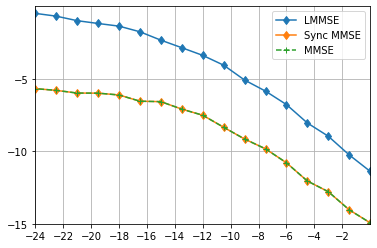

In [23]:
plt.plot(all_sinr, 10*np.log10(all_mse[:,-3].reshape(-1,n_per_sinr).mean(axis=-1)),'d-', label='LMMSE')
plt.plot(all_sinr, 10*np.log10(all_mse[:,-2].reshape(-1,n_per_sinr).mean(axis=-1)),'d-', label='Sync MMSE')
plt.plot(all_sinr, 10*np.log10(all_mse[:,-1].reshape(-1,n_per_sinr).mean(axis=-1)),'+--', label='MMSE')

# plt.plot(all_sinr, 10*np.log10(all_mse[:,0].reshape(-1,n_per_sinr).mean(axis=-1)),'x-', label='U-Net trained for Gaussian')
# plt.plot(all_sinr, 10*np.log10(all_mse[:,1].reshape(-1,n_per_sinr).mean(axis=-1)),'x-', label='U-Net trained for Comm')

plt.legend()
plt.xlim(xmax = 0, xmin = -24)
plt.ylim(ymax = 0, ymin = -15)
plt.grid()
plt.xticks(np.arange(-24, 0, step=2))
plt.yticks(np.arange(-15, 0, step=5))

ta_mse = 10*np.log10(all_mse.mean(axis=0))
methods = ['LMMSE', 'Oracle QLMMSE', 'MMSE']

for n,m in zip(methods, ta_mse):
    print(f'{n:>20}: {m:.03f} dB')
print()

In [21]:
mse_lmmse_data = np.stack((all_sinr, 10*np.log10(all_mse[:,-3].reshape(-1,n_per_sinr).mean(axis=-1))),axis=1)
np.savetxt("data/mse_lmmse_data_sync_sec.csv", mse_lmmse_data, delimiter=",")
                          
mse_qlmmse_data = np.stack((all_sinr, 10*np.log10(all_mse[:,-2].reshape(-1,n_per_sinr).mean(axis=-1))),axis=1)
np.savetxt("data/mse_qlmmse_data_sync_sec.csv", mse_qlmmse_data, delimiter=",")
                           
mse_mmse_data = np.stack((all_sinr, 10*np.log10(all_mse[:,-1].reshape(-1,n_per_sinr).mean(axis=-1))),axis=1)
np.savetxt("data/mse_mmse_data_sync_sec.csv", mse_mmse_data, delimiter=",")